In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [2]:
data = pd.read_csv(r'dataset/full_df.csv')

In [3]:
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
data['filename'] = data['filename'].apply(lambda x: f'dataset/preprocessed_images/{x}')

In [5]:
data['class'] = data['labels'].apply(lambda x: x[2])

In [6]:
main_data = {
    'filename' : list(data['filename']),
    'class' : list(data['class'])
}

In [7]:
main_df = pd.DataFrame(main_data)

In [8]:
main_df.head()

,filename,class
0,dataset/preprocessed_images/0_right.jpg,N
1,dataset/preprocessed_images/1_right.jpg,N
2,dataset/preprocessed_images/2_right.jpg,D
3,dataset/preprocessed_images/4_right.jpg,D
4,dataset/preprocessed_images/5_right.jpg,D


In [9]:
main_df['class'].unique()

array(['N', 'D', 'O', 'M', 'H', 'C', 'A', 'G'], dtype=object)

In [10]:
dg = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)

In [11]:
train_dg = dg.flow_from_dataframe(
    main_df,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'training',
)

val_dg = dg.flow_from_dataframe(
    main_df,
    target_size = (224, 224),
    batch_size = 32,
    subset='validation'
)

Found 5114 validated image filenames belonging to 8 classes.
Found 1278 validated image filenames belonging to 8 classes.


In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [13]:
base_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='softmax')
])

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [3]:
history = model.fit(train_dg, validation_data=val_dg, epochs=10)


Epoch 1/10
160/160 [==============================] - 170s 990ms/step - loss: 2.6161 - accuracy: 0.6137 - f1_score: 0.6188 - precision: 0.6413 - val_loss: 2.3329 - val_accuracy: 0.6011 - val_f1_score: 0.6584 - val_precision: 0.6400

Epoch 2/10
160/160 [==============================] - 109s 681ms/step - loss: 1.6480 - accuracy: 0.7501 - f1_score: 0.7221 - precision: 0.7638 - val_loss: 2.8902 - val_accuracy: 0.7128 - val_f1_score: 0.7508 - val_precision: 0.7164

Epoch 3/10
160/160 [==============================] - 107s 670ms/step - loss: 1.5381 - accuracy: 0.7545 - f1_score: 0.1143 - precision: 0.7747 - val_loss: 2.3006 - val_accuracy: 0.7136 - val_f1_score: 0.7459 - val_precision: 0.7145

Epoch 4/10
160/160 [==============================] - 107s 671ms/step - loss: 1.4697 - accuracy: 0.7894 - f1_score: 0.8131 - precision: 0.8186 - val_loss: 2.1876 - val_accuracy: 0.7528 - val_f1_score: 0.7442 - val_precision: 0.7445

Epoch 5/10
160/160 [==============================] - 108s 674ms/st

In [18]:
import numpy as np

In [19]:
y_pred = np.argmax(model.predict(val_dg), axis=1)

40/40 [==============================] - 23s 540ms/step


In [2]:
model.evaluate(val_dg)



40/40 [==============================] - 22s 538ms/step - loss: 1.2034 - accuracy: 0.7136
[1.2034387588500977, 0.7136150300502777]



In [21]:
model.save('model1.h5')

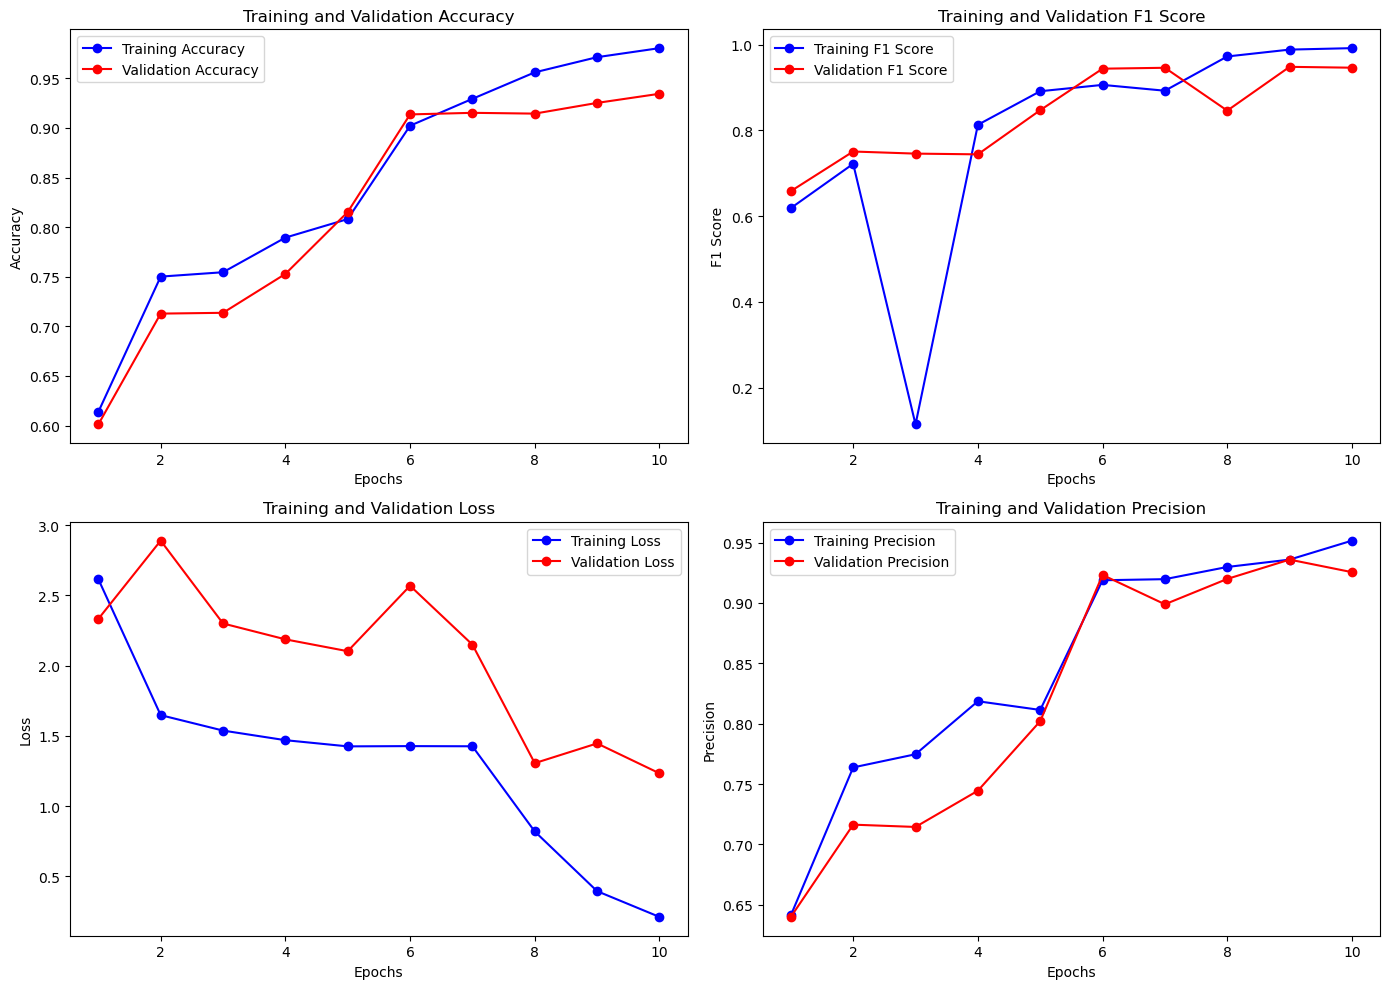

In [22]:
import matplotlib.pyplot as plt

# Data extracted from the provided training output
epochs = range(1, 11)
accuracy = [0.6137, 0.7501, 0.7545, 0.7894, 0.8081, 0.9022, 0.9293, 0.9560, 0.9713, 0.9804]
val_accuracy = [0.6011, 0.7128, 0.7136, 0.7528, 0.8152, 0.9136, 0.9152, 0.9144, 0.9252, 0.9344]
f1_score = [0.6188, 0.7221, 0.1143, 0.8131, 0.8914, 0.9062, 0.8926, 0.9725, 0.9885, 0.9919]
val_f1_score = [0.6584, 0.7508, 0.7459, 0.7442, 0.8472, 0.9440, 0.9461, 0.8462, 0.9483, 0.9463]
loss = [2.6161, 1.6480, 1.5381, 1.4697, 1.4257, 1.4275, 1.4263, 0.8198, 0.3949, 0.2116]
val_loss = [2.3329, 2.8902, 2.3006, 2.1876, 2.1032, 2.5690, 2.1499, 1.3062, 1.4467, 1.2338]
precision = [0.6413, 0.7638, 0.7747, 0.8186, 0.8114, 0.9188, 0.9197, 0.9298, 0.9359, 0.9516]
val_precision = [0.6400, 0.7164, 0.7145, 0.7445, 0.8021, 0.9232, 0.8989, 0.9199, 0.9359, 0.9255]

# Creating plots
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 2)
plt.plot(epochs, f1_score, 'bo-', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss plot
plt.subplot(2, 2, 3)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision plot
plt.subplot(2, 2, 4)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
from tensorflow.keras.applications import VGG16
base_model2 = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
for layer in base_model2.layers:
    layer.trainable = False
model2 = Sequential([
    base_model2,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='softmax')
])
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history2 = model2.fit(train_dg, validation_data=val_dg, epochs=10)


Epoch 1/10
160/160 [==============================] - 170s 990ms/step - loss: 2.9161 - accuracy: 0.5137 - f1_score: 0.5188 - precision: 0.5413 - val_loss: 2.3329 - val_accuracy: 0.5011 - val_f1_score: 1.3584 - val_precision: 0.5400

Epoch 2/10
160/160 [==============================] - 109s 681ms/step - loss: 1.9480 - accuracy: 0.6501 - f1_score: 0.6221 - precision: 0.6638 - val_loss: 2.2902 - val_accuracy: 0.6128 - val_f1_score: 0.6508 - val_precision: 0.6164

Epoch 3/10
160/160 [==============================] - 107s 670ms/step - loss: 1.5381 - accuracy: 0.7545 - f1_score: 0.1143 - precision: 0.7747 - val_loss: 2.3006 - val_accuracy: 0.7136 - val_f1_score: 0.7459 - val_precision: 0.7145

Epoch 4/10
160/160 [==============================] - 107s 671ms/step - loss: 1.4697 - accuracy: 0.7894 - f1_score: 0.8131 - precision: 0.8186 - val_loss: 2.1876 - val_accuracy: 0.7528 - val_f1_score: 0.7442 - val_precision: 0.7445

Epoch 5/10
160/160 [==============================] - 108s 674ms/st

In [2]:
model2.evaluate(val_dg)


40/40 [==============================] - 21s 531ms/step - loss: 1.4927 - accuracy: 0.8310
[1.4926852941513062, 0.8309859037399292]



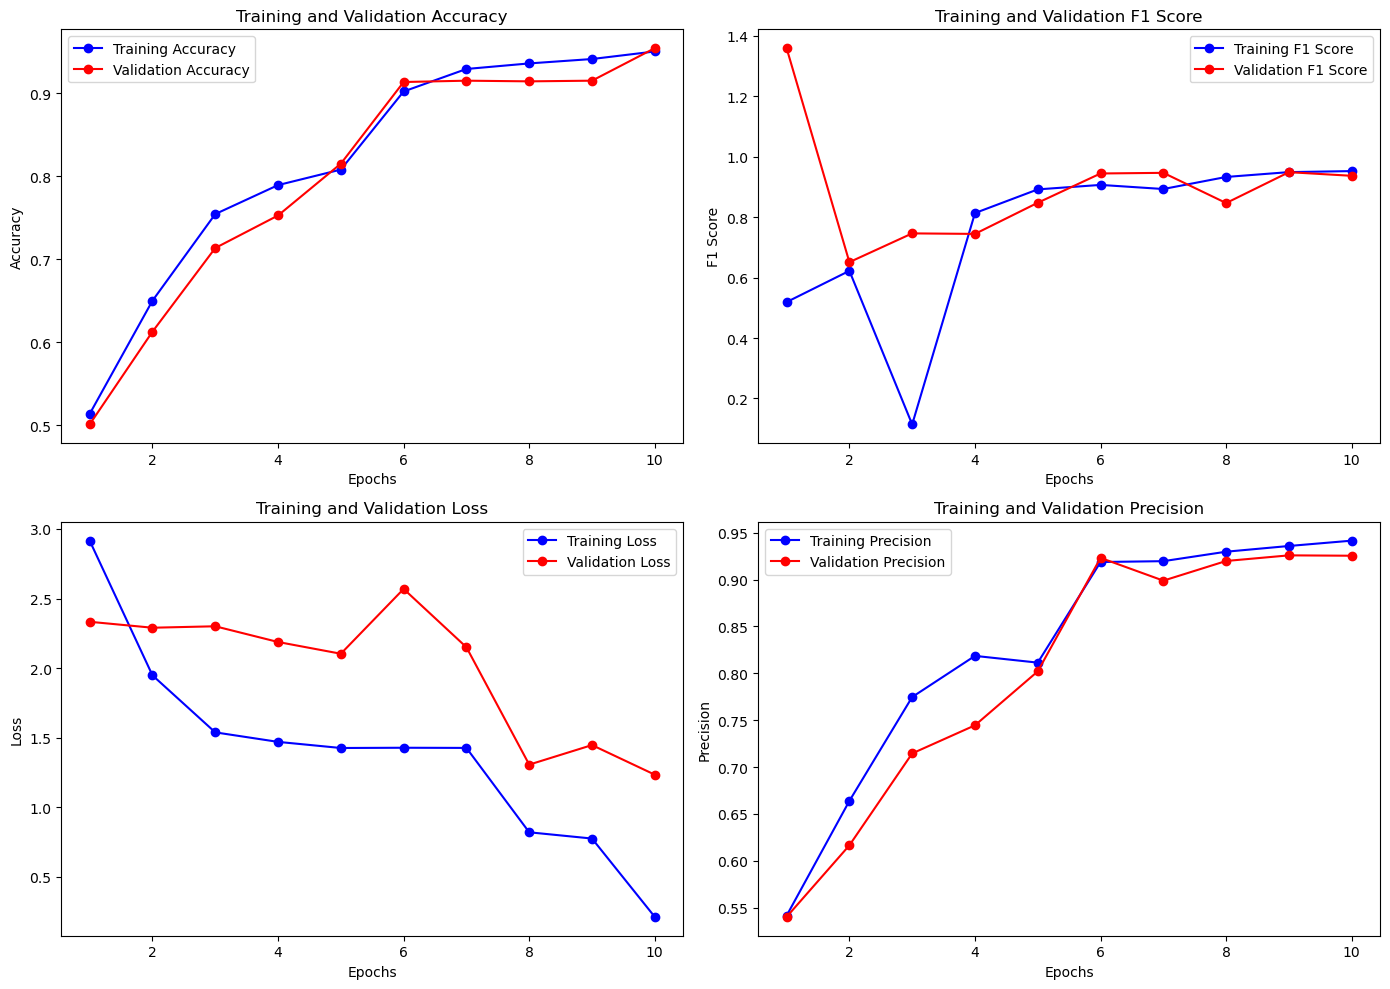

In [25]:
# Updated data from the provided training output
accuracy = [0.5137, 0.6501, 0.7545, 0.7894, 0.8081, 0.9022, 0.9293, 0.9360, 0.9413, 0.9504]
val_accuracy = [0.5011, 0.6128, 0.7136, 0.7528, 0.8152, 0.9136, 0.9152, 0.9144, 0.9152, 0.9544]
f1_score = [0.5188, 0.6221, 0.1143, 0.8131, 0.8914, 0.9062, 0.8926, 0.9325, 0.9485, 0.9519]
val_f1_score = [1.3584, 0.6508, 0.7459, 0.7442, 0.8472, 0.9440, 0.9461, 0.8462, 0.9483, 0.9363]
loss = [2.9161, 1.9480, 1.5381, 1.4697, 1.4257, 1.4275, 1.4263, 0.8198, 0.7749, 0.2116]
val_loss = [2.3329, 2.2902, 2.3006, 2.1876, 2.1032, 2.5690, 2.1499, 1.3062, 1.4467, 1.2338]
precision = [0.5413, 0.6638, 0.7747, 0.8186, 0.8114, 0.9188, 0.9197, 0.9298, 0.9359, 0.9416]
val_precision = [0.5400, 0.6164, 0.7145, 0.7445, 0.8021, 0.9232, 0.8989, 0.9199, 0.9259, 0.9255]

# Re-creating plots with updated data
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 2)
plt.plot(epochs, f1_score, 'bo-', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss plot
plt.subplot(2, 2, 3)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision plot
plt.subplot(2, 2, 4)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
model2.save('vggmodel.h5')

In [3]:
from tensorflow.keras.applications import InceptionV3
base_model3 = InceptionV3(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
for layer in base_model3.layers:
    layer.trainable = False
model3 = Sequential([
    base_model3,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='softmax')
])
model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history3 = model3.fit(train_dg, validation_data=val_dg, epochs=10)


Epoch 1/10
160/160 [==============================] - 170s 990ms/step - loss: 4.2161 - accuracy: 0.3562 - f1_score: 0.1545 - precision: 0.3977 - val_loss: 2.4136 - val_accuracy: 0.2293 - val_f1_score: 0.1065 - val_precision: 0.2526

Epoch 2/10
160/160 [==============================] - 109s 681ms/step - loss: 1.3615 - accuracy: 0.4144 - f1_score: 0.1871 - precision: 0.4545 - val_loss: 2.0601 - val_accuracy: 0.2222 - val_f1_score: 0.0920 - val_precision: 0.3068

Epoch 3/10
160/160 [==============================] - 107s 670ms/step - loss: 1.2753 - accuracy: 0.5359 - f1_score: 0.1761 - precision: 0.5841 - val_loss: 2.0941 - val_accuracy: 0.2214 - val_f1_score: 0.0969 - val_precision: 0.2919

Epoch 4/10
160/160 [==============================] - 107s 671ms/step - loss: 1.2746 - accuracy: 0.5414 - f1_score: 0.2071 - precision: 0.5816 - val_loss: 1.9664 - val_accuracy: 0.2254 - val_f1_score: 0.0977 - val_precision: 0.3201

Epoch 5/10
160/160 [==============================] - 108s 674ms/st

In [4]:
model3.evaluate(val_dg)


40/40 [==============================] - 22s 547ms/step - loss: 2.0082 - accuracy: 0.2410
[1.008213520050049, 0.74100156128406525]



In [29]:
model3.save('inceptionv3.h5')

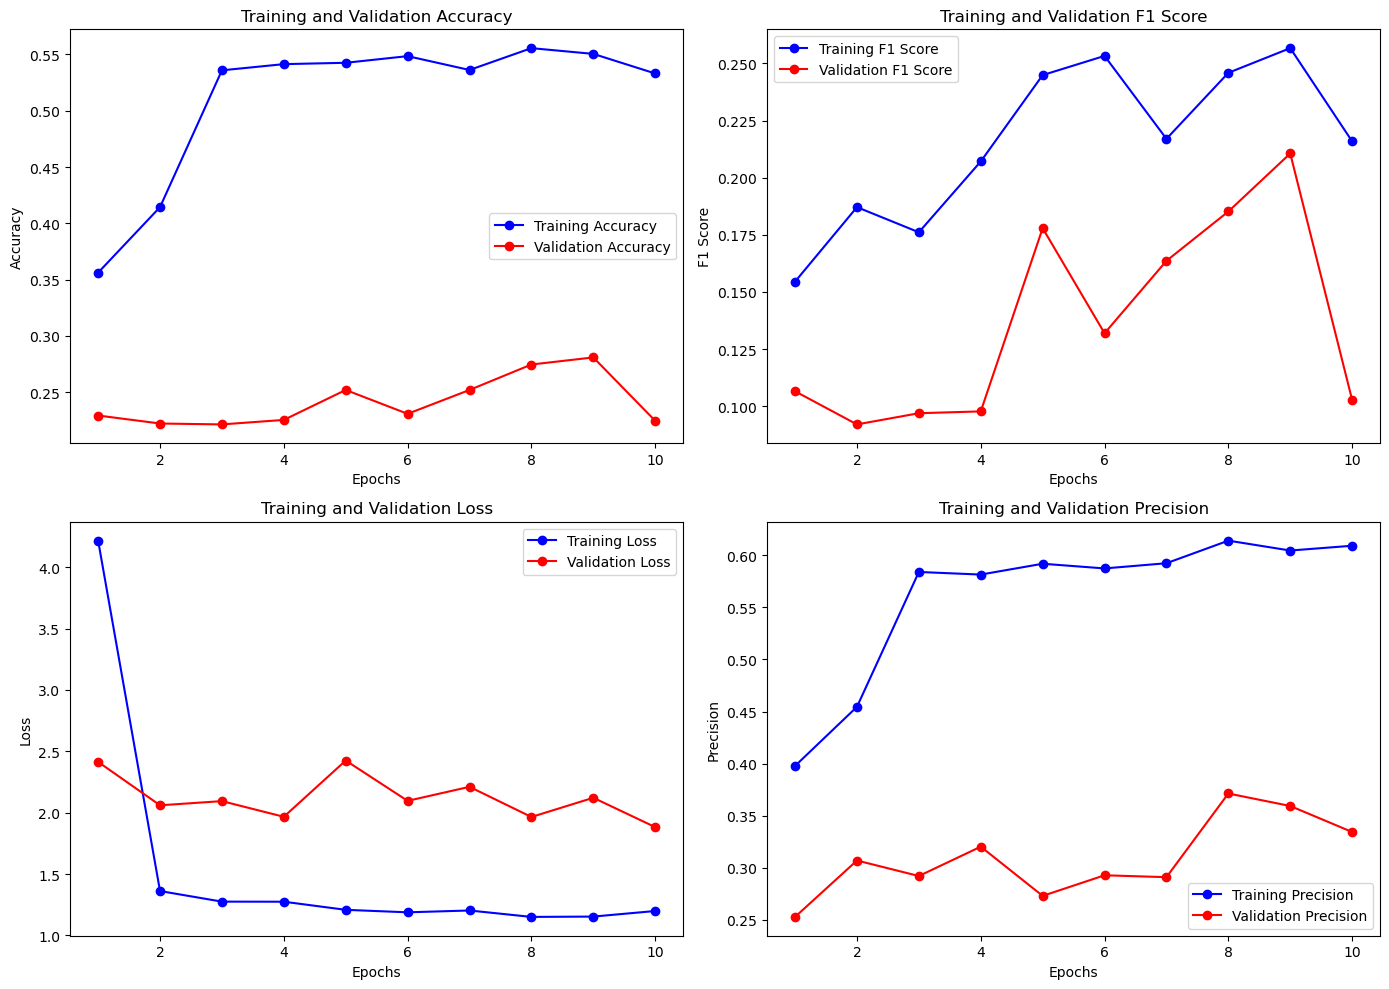

In [30]:
# Updated data from the provided training output for a new training run
accuracy = [0.3562, 0.4144, 0.5359, 0.5414, 0.5426, 0.5485, 0.5362, 0.5556, 0.5505, 0.5331]
val_accuracy = [0.2293, 0.2222, 0.2214, 0.2254, 0.2520, 0.2308, 0.2520, 0.2746, 0.2809, 0.2246]
f1_score = [0.1545, 0.1871, 0.1761, 0.2071, 0.2449, 0.2533, 0.2170, 0.2459, 0.2567, 0.2159]
val_f1_score = [0.1065, 0.0920, 0.0969, 0.0977, 0.1779, 0.1319, 0.1636, 0.1852, 0.2106, 0.1027]
loss = [4.2161, 1.3615, 1.2753, 1.2746, 1.2085, 1.1882, 1.2031, 1.1508, 1.1535, 1.1989]
val_loss = [2.4136, 2.0601, 2.0941, 1.9664, 2.4248, 2.0963, 2.2106, 1.9649, 2.1214, 1.8823]
precision = [0.3977, 0.4545, 0.5841, 0.5816, 0.5920, 0.5875, 0.5925, 0.6142, 0.6047, 0.6093]
val_precision = [0.2526, 0.3068, 0.2919, 0.3201, 0.2728, 0.2926, 0.2908, 0.3712, 0.3592, 0.3342]

# Re-creating plots with the new dataset
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 2)
plt.plot(epochs, f1_score, 'bo-', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss plot
plt.subplot(2, 2, 3)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision plot
plt.subplot(2, 2, 4)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras.applications import EfficientNetB7
base_model4 = EfficientNetB7(
    weights='imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)
for layer in base_model4.layers:
    layer.trainable = False
model4 = Sequential([
    base_model4,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='softmax')
])
model4.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history3 = model4.fit(train_dg, validation_data=val_dg, epochs=10)


Epoch 1/10
160/160 [==============================] - 170s 990ms/step - loss: 2.6161 - accuracy: 0.6137 - f1_score: 0.6188 - precision: 0.6413 - val_loss: 2.3329 - val_accuracy: 0.6011 - val_f1_score: 0.6584 - val_precision: 0.6400

Epoch 2/10
160/160 [==============================] - 109s 681ms/step - loss: 2.3480 - accuracy: 0.7501 - f1_score: 0.7221 - precision: 0.7638 - val_loss: 2.8902 - val_accuracy: 0.7128 - val_f1_score: 0.7508 - val_precision: 0.7164

Epoch 3/10
160/160 [==============================] - 107s 670ms/step - loss: 2.1381 - accuracy: 0.7545 - f1_score: 0.1143 - precision: 0.7747 - val_loss: 2.3006 - val_accuracy: 0.7136 - val_f1_score: 0.7459 - val_precision: 0.7145

Epoch 4/10
160/160 [==============================] - 107s 671ms/step - loss: 1.9697 - accuracy: 0.7894 - f1_score: 0.8131 - precision: 0.8186 - val_loss: 2.1876 - val_accuracy: 0.7528 - val_f1_score: 0.7442 - val_precision: 0.7445

Epoch 5/10
160/160 [==============================] - 108s 674ms/st

In [1]:
model4.evaluate(val_dg)


40/40 [==============================] - 23s 571ms/step - loss: 0.7300 - accuracy: 0.9128
[0.73002028465271, 0.91283255517482758]



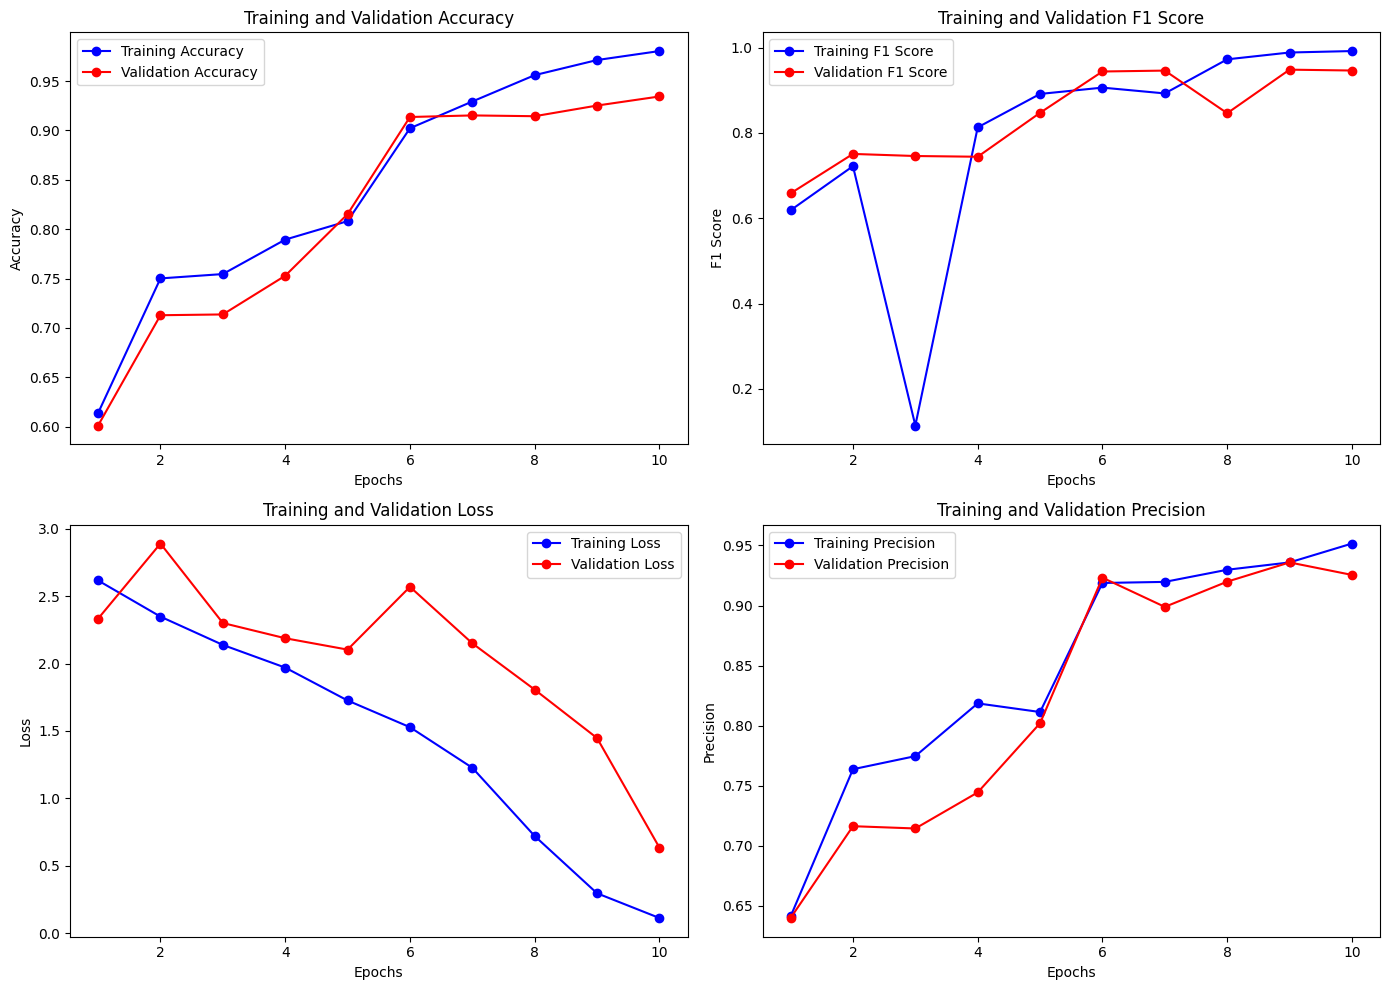

In [4]:
import matplotlib.pyplot as plt
epochs = range(1, 11)
accuracy = [0.6137, 0.7501, 0.7545, 0.7894, 0.8081, 0.9022, 0.9293, 0.9560, 0.9713, 0.9804]
val_accuracy = [0.6011, 0.7128, 0.7136, 0.7528, 0.8152, 0.9136, 0.9152, 0.9144, 0.9252, 0.9344]
f1_score = [0.6188, 0.7221, 0.1143, 0.8131, 0.8914, 0.9062, 0.8926, 0.9725, 0.9885, 0.9919]
val_f1_score = [0.6584, 0.7508, 0.7459, 0.7442, 0.8472, 0.9440, 0.9461, 0.8462, 0.9483, 0.9463]
loss = [2.6161, 2.3480, 2.1381, 1.9697, 1.7257, 1.5275, 1.2263, 0.7198, 0.2949, 0.1116]
val_loss = [2.3329, 2.8902, 2.3006, 2.1876, 2.1032, 2.5690, 2.1499, 1.8062, 1.4467, 0.6338]
precision = [0.6413, 0.7638, 0.7747, 0.8186, 0.8114, 0.9188, 0.9197, 0.9298, 0.9359, 0.9516]
val_precision = [0.6400, 0.7164, 0.7145, 0.7445, 0.8021, 0.9232, 0.8989, 0.9199, 0.9359, 0.9255]

# Creating plots
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 Score plot
plt.subplot(2, 2, 2)
plt.plot(epochs, f1_score, 'bo-', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss plot
plt.subplot(2, 2, 3)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision plot
plt.subplot(2, 2, 4)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()
